In [70]:
import numpy as np
import pandas as pd
import seaborn as sns

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt


# Load data

In [71]:
data_file = 'data/house.csv'
housing = pd.read_csv(data_file)

# First look at the data

In [72]:
housing.describe()

,id,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,0.067783,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.673622e+05,0.251379,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,0.000000,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,0.000000,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,0.000000,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,1.000000,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [73]:
housing.head()

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


The 'id' column is of no use for us, and therefore can be dropped

In [74]:
housing.drop(['id'], axis=1, inplace=True)

The 'date' column could be much nicer, lets go ahead and do that:

In [75]:
housing['date'] = pd.to_datetime(housing['date'])

In [76]:
housing.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Already looking a bit better, lets now take a look at the distributions.

# Preliminary cleaning

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe86a830a30>,
      dtype=object)

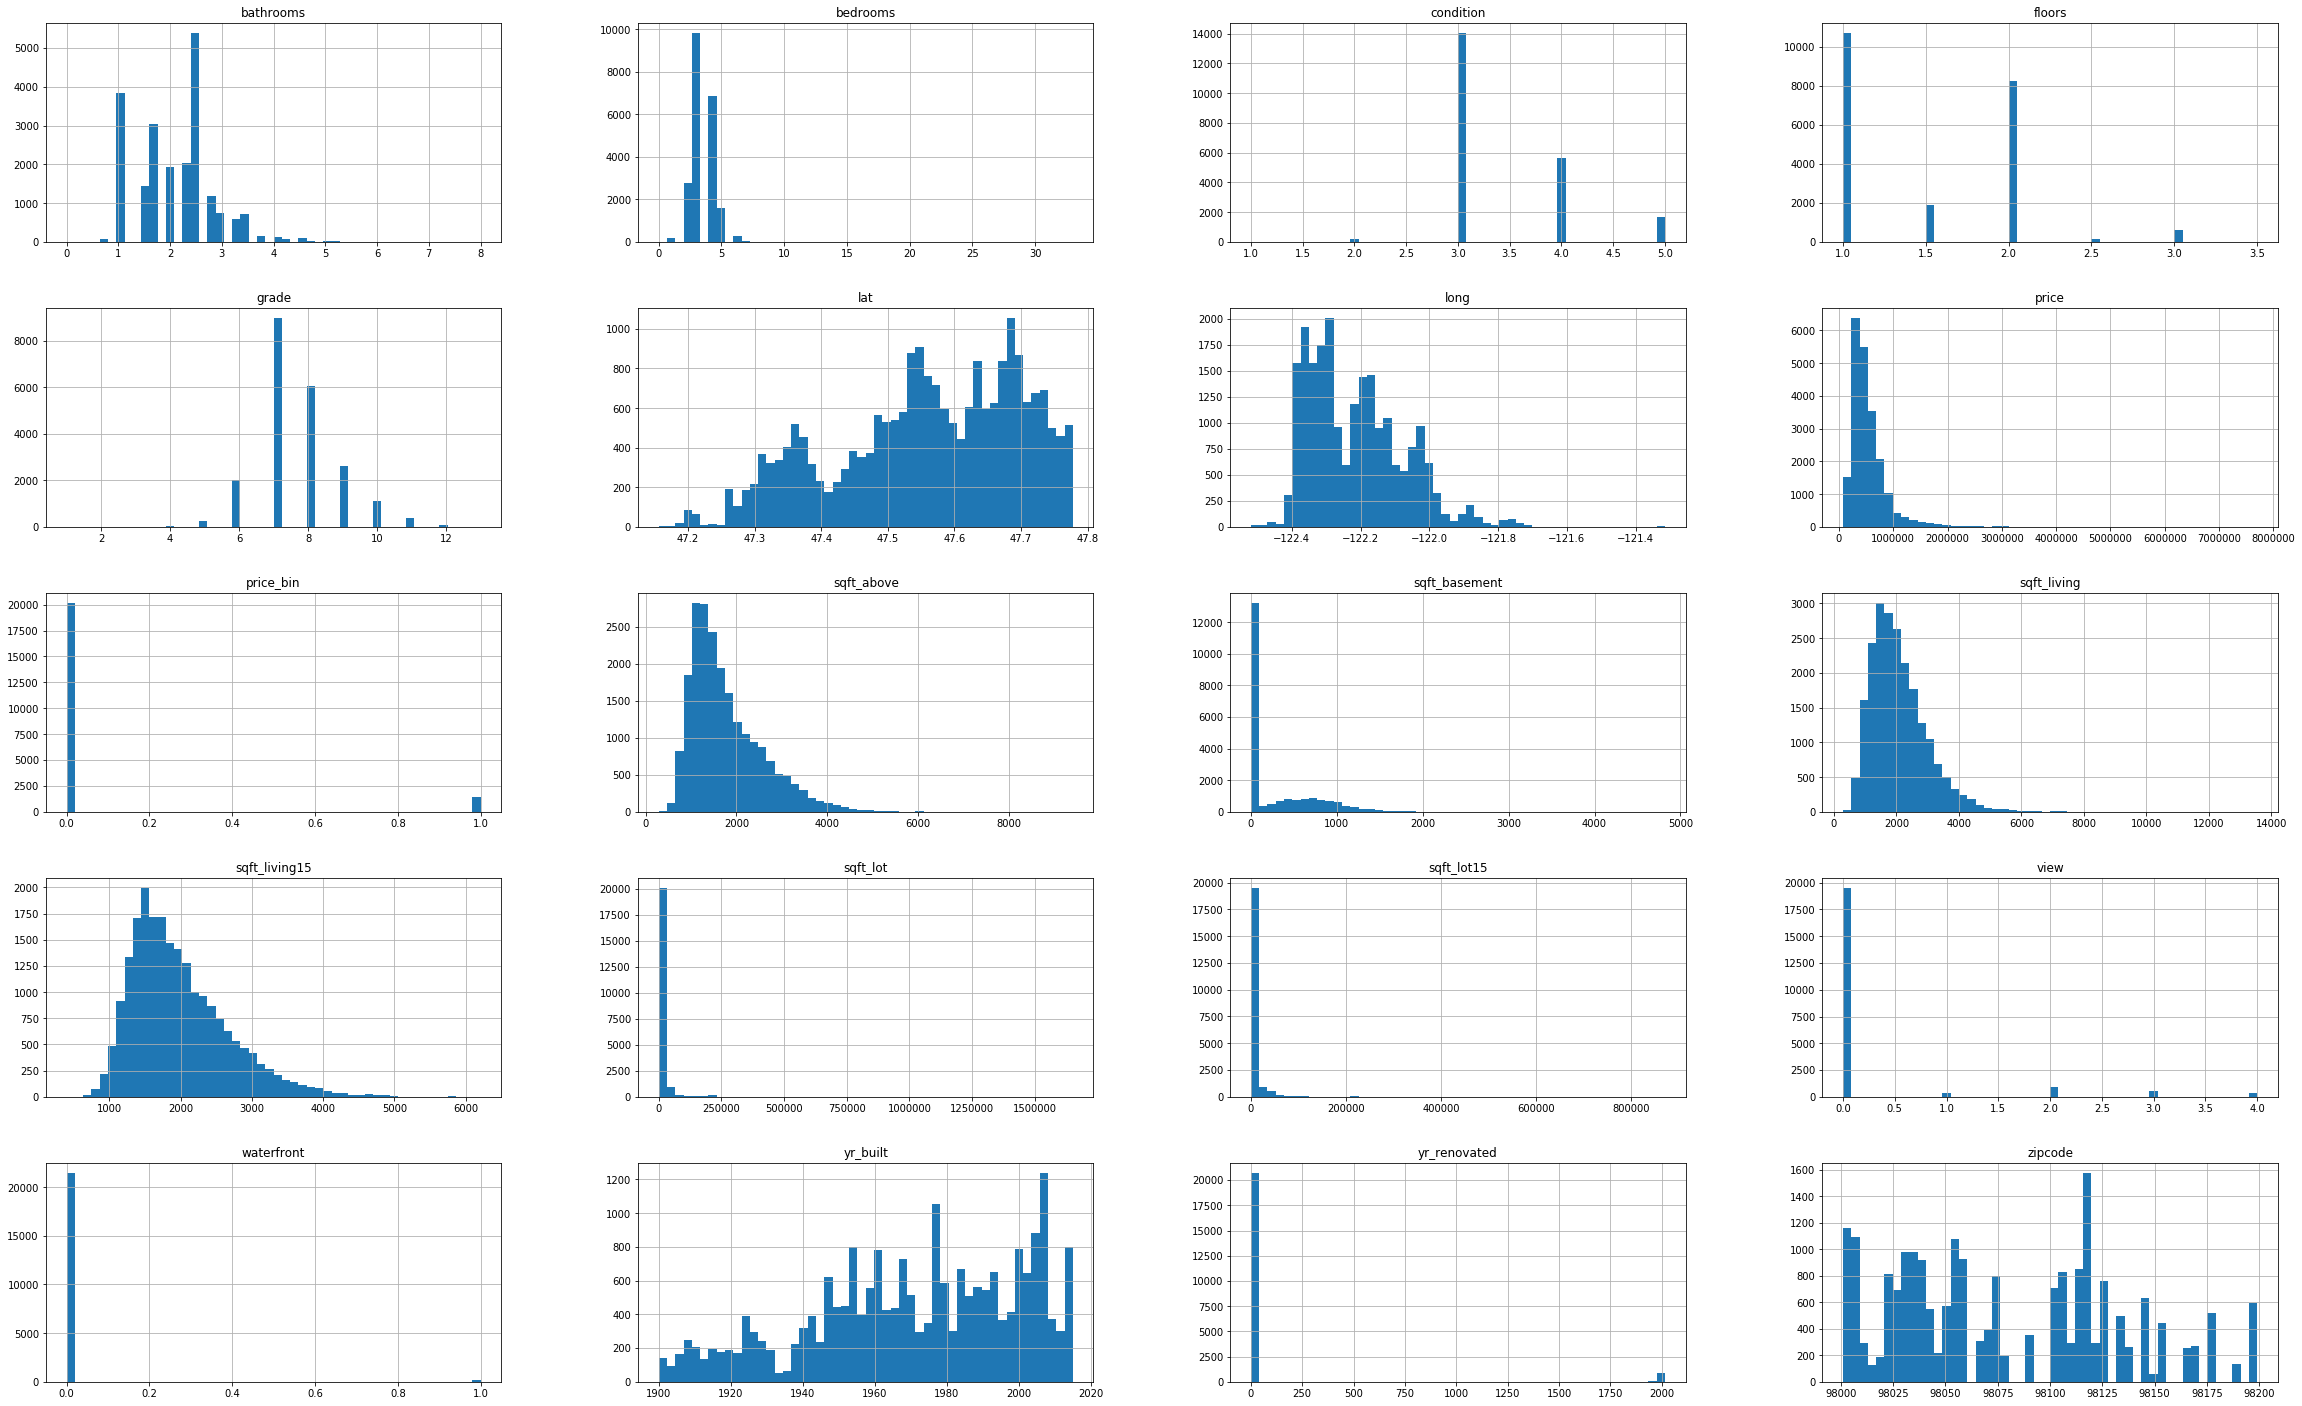

In [77]:
housing.hist(bins=50, figsize=(40, 25))

We can already see some possible problems with this dataset - especially with bedrooms, price and sqft_lot, sqft_lot15, which have a very long-tailed distribution, indicating several outliers. This might be pesky to deal with later, so we will try to clean it up before creating a model

Let's see what we can do with the bedrooms first.

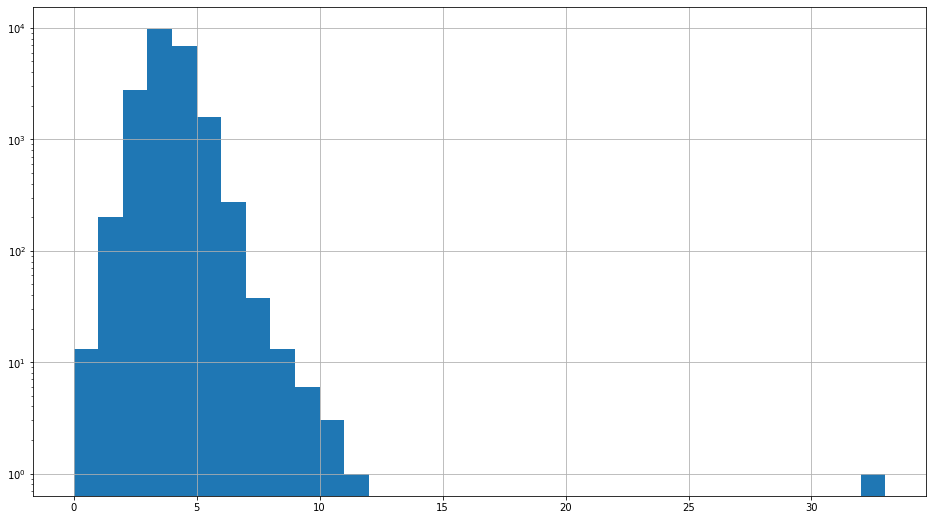

In [78]:
# Histogram with logarythmic scale to better visualize the outlier
housing['bedrooms'].hist(bins=33, log=True, figsize=(16, 9))

In [79]:
counts = housing['bedrooms'].value_counts(ascending=True)
print(counts)

33       1
11       1
10       3
9        6
0       13
8       13
7       38
1      199
6      272
5     1601
2     2760
4     6882
3     9824
Name: bedrooms, dtype: int64


As suspected, we have the most data in the 1-6 bedroom range, with several outliers - one of the houses has 33 bedrooms, and some of them have none (!).

In [80]:
bedroom_outlier = housing.loc[(housing['bedrooms'] > 6) | (housing['bedrooms'] == 0)]
bedroom_outlier.head()

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
556,2014-06-20,1950000.0,1,7,3.5,4640,15235,2.0,0,1,...,11,2860,1780,1965,2003,98040,47.5666,-122.231,3230,20697
875,2014-06-12,1100000.0,1,0,0.0,3064,4764,3.5,0,2,...,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
1135,2015-01-05,420000.0,0,7,3.0,2940,8624,1.0,0,0,...,8,1690,1250,1977,0,98155,47.7555,-122.307,1850,8031
1241,2014-06-23,350000.0,0,7,3.0,2800,9569,1.0,0,2,...,7,1400,1400,1963,0,98056,47.5102,-122.183,2150,7333
1660,2014-12-04,490000.0,0,8,5.0,2800,2580,2.0,0,0,...,8,1880,920,1997,0,98122,47.6086,-122.303,1800,2580


In [81]:
bedroom_outlier.describe()

,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,7.500000e+01,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000,75.0,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,8.645055e+05,0.226667,6.640000,3.163333,3480.16000,17237.706667,1.786667,0.0,0.373333,3.346667,7.960000,2737.360000,742.800000,1961.920000,160.186667,98082.400000,47.599492,-122.236853,2220.640000,14636.853333
std,7.003739e+05,0.421495,4.323537,1.684334,1861.82113,42176.862882,0.605009,0.0,0.911982,0.725842,1.796694,1443.312188,814.370193,32.293318,546.884016,48.431339,0.105169,0.131635,855.898084,35292.932515
min,1.399500e+05,0.000000,0.000000,0.000000,290.00000,979.000000,1.000000,0.0,0.000000,1.000000,1.000000,290.000000,0.000000,1901.000000,0.000000,98001.000000,47.278100,-122.491000,1060.000000,1399.000000
25%,4.250000e+05,0.000000,7.000000,2.500000,2600.00000,5000.000000,1.000000,0.0,0.000000,3.000000,7.000000,1870.000000,0.000000,1947.500000,0.000000,98039.500000,47.534400,-122.323000,1550.000000,4405.000000
50%,6.400000e+05,0.000000,7.000000,3.000000,3150.00000,8145.000000,2.000000,0.0,0.000000,3.000000,8.000000,2530.000000,600.000000,1964.000000,0.000000,98103.000000,47.626300,-122.289000,2010.000000,7479.000000
75%,9.430000e+05,0.000000,8.000000,4.000000,4215.00000,12314.000000,2.000000,0.0,0.000000,4.000000,9.000000,3215.000000,1305.000000,1988.500000,0.000000,98117.000000,47.668400,-122.168000,2515.000000,10202.500000
max,3.300000e+06,1.000000,33.000000,8.000000,13540.00000,307752.000000,3.500000,0.0,4.000000,5.000000,12.000000,9410.000000,4130.000000,2013.000000,2013.000000,98199.000000,47.756500,-121.826000,4850.000000,224341.000000


As we have only 75 entries with 'unusual' number of bedrooms, which is ~0.3% of our data, we will just get rid of those records.

In [82]:
housing.drop(housing[(housing['bedrooms'] > 6) | (housing['bedrooms'] == 0)].index, inplace=True)

Let's focus on the price now

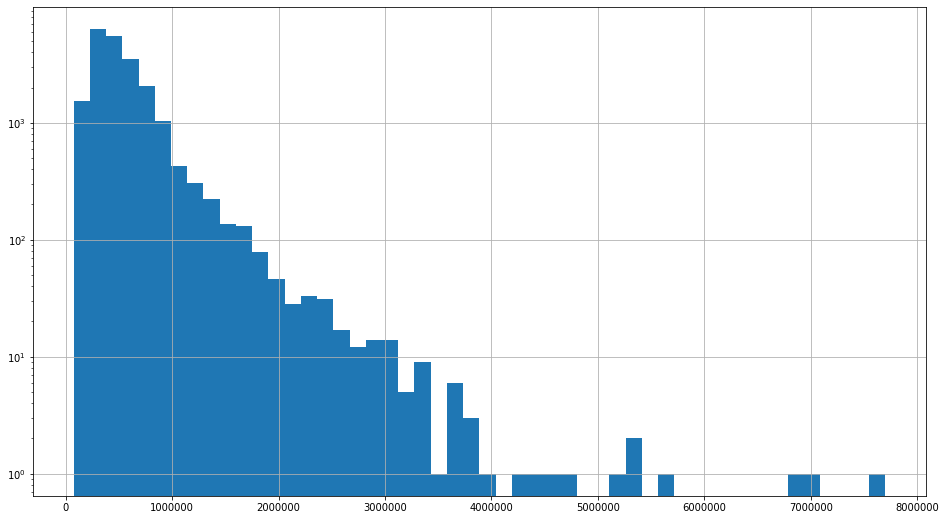

In [83]:
housing['price'].hist(bins=50, log=True, figsize=(16, 9))

In [112]:
price_threshold = 1000000
housing[housing['price'] > price_threshold]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5,2014-05-12,1230000.0,1,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
21,2014-08-26,2000000.0,1,3,2.75,3050,44867,1.0,0,4,...,9,2330,720,1968,0,98040,47.5316,-122.233,4110,20336
49,2015-03-11,1350000.0,1,3,2.50,2753,65005,1.0,1,2,...,9,2165,588,1953,0,98070,47.4041,-122.451,2680,72513
69,2014-06-12,1330000.0,1,5,2.25,3200,20158,1.0,0,0,...,8,1600,1600,1965,0,98004,47.6303,-122.215,3390,20158
70,2014-09-12,1040000.0,1,5,3.25,4770,50094,1.0,0,0,...,11,3070,1700,1973,0,98005,47.6525,-122.160,3530,38917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21590,2014-05-14,1220000.0,1,4,3.50,4910,9444,1.5,0,0,...,11,3110,1800,2007,0,98074,47.6502,-122.066,4560,11063
21593,2015-03-17,1090000.0,1,5,3.75,4170,8142,2.0,0,2,...,10,4170,0,2006,0,98056,47.5354,-122.181,3030,7980
21597,2015-04-21,1580000.0,1,4,3.25,3410,10125,2.0,0,0,...,10,3410,0,2007,0,98040,47.5653,-122.223,2290,10125
21600,2014-10-15,1540000.0,1,5,3.75,4470,8088,2.0,0,0,...,11,4470,0,2008,0,98004,47.6321,-122.200,2780,8964


Once again, 11 values represent the upper half of the price range. This raises a question if we will be able to accurately train model for this price range, and would not it be better to delegate this task to an expert, as the cases are rare. Other option is training a separate model, just for the 'high-end'. 

Of course, this would depend on the bussiness requirements - can we deliver predictions just to a certain threshold (e.g. 4kk), or can we compromise on accuracy by serving predictions for the entire price range of the dataset.

For now, the main focus will be on the more moderate price range, and values above the threshold will be disregarded.

In [113]:
housing.drop(housing[(housing['price'] > price_threshold)].index, inplace=True)

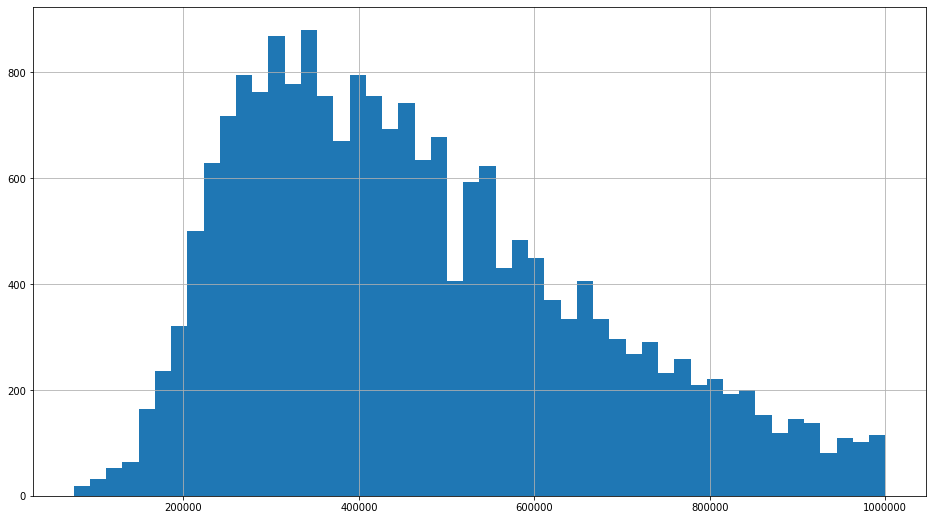

In [114]:
housing['price'].hist(bins=50, figsize=(16, 9))

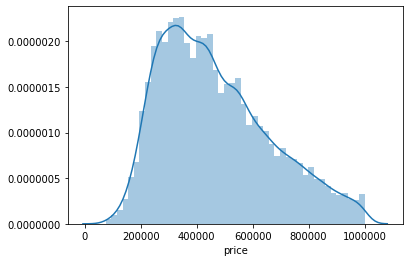

In [140]:
sns.distplot(housing['price'])

Still not perfect, but much better looking than the original distribution. We will see how the served predictions will look like, but it might be worth investigating if we can train model for only price range up to 1kk.

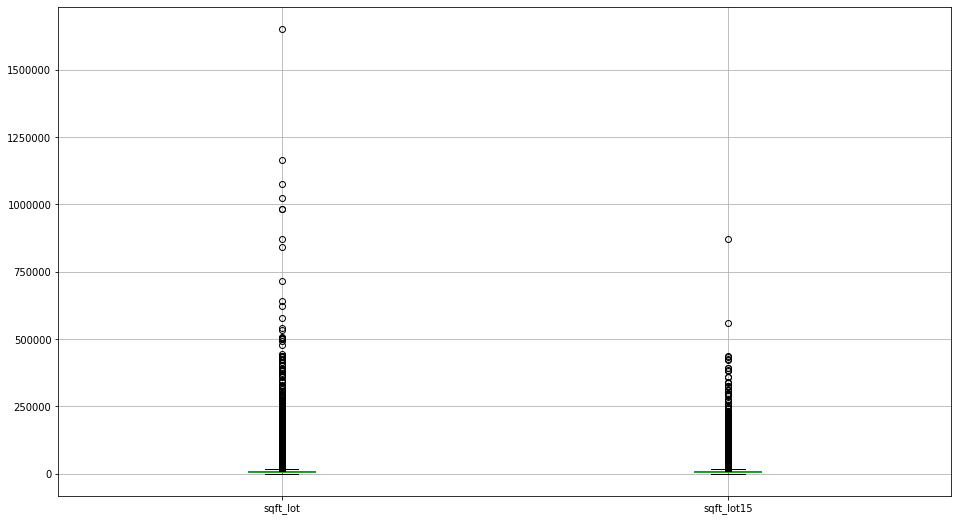

In [115]:
housing.boxplot(column=['sqft_lot', 'sqft_lot15'], figsize=(16, 9))

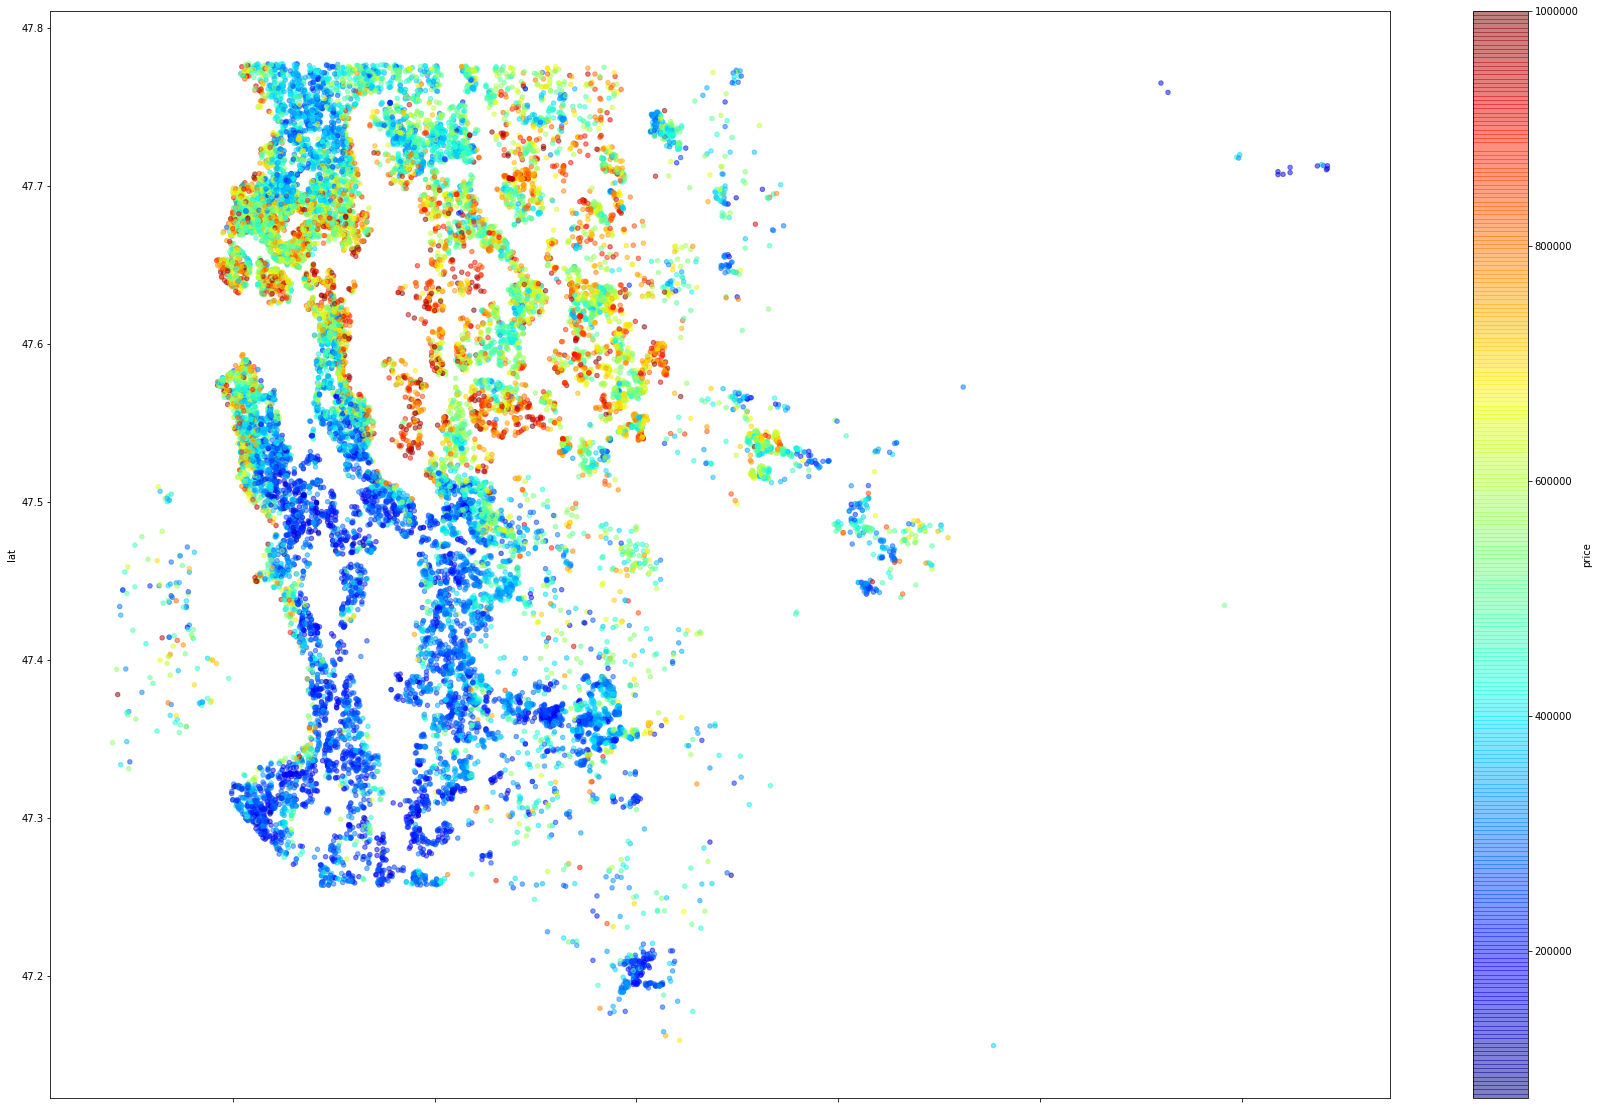

In [119]:
housing.plot(kind='scatter', x='long', y='lat', alpha=0.5,
            c='price', cmap=plt.get_cmap('jet'), colorbar=True, 
            figsize=(30, 20))

In [127]:
correlation_matrix = housing.corr()
correlations = correlation_matrix['price'].sort_values(ascending=False)
print(correlations)

price            1.000000
grade            0.617807
sqft_living      0.604480
sqft_living15    0.549943
sqft_above       0.515337
lat              0.440706
bathrooms        0.439446
bedrooms         0.295159
floors           0.269656
sqft_basement    0.221034
view             0.214802
sqft_lot         0.094336
sqft_lot15       0.082395
long             0.078335
yr_renovated     0.075654
yr_built         0.059680
waterfront       0.052895
price_bin        0.042771
condition        0.033552
zipcode         -0.019298
Name: price, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe865b26d90>,
      dtype=object)

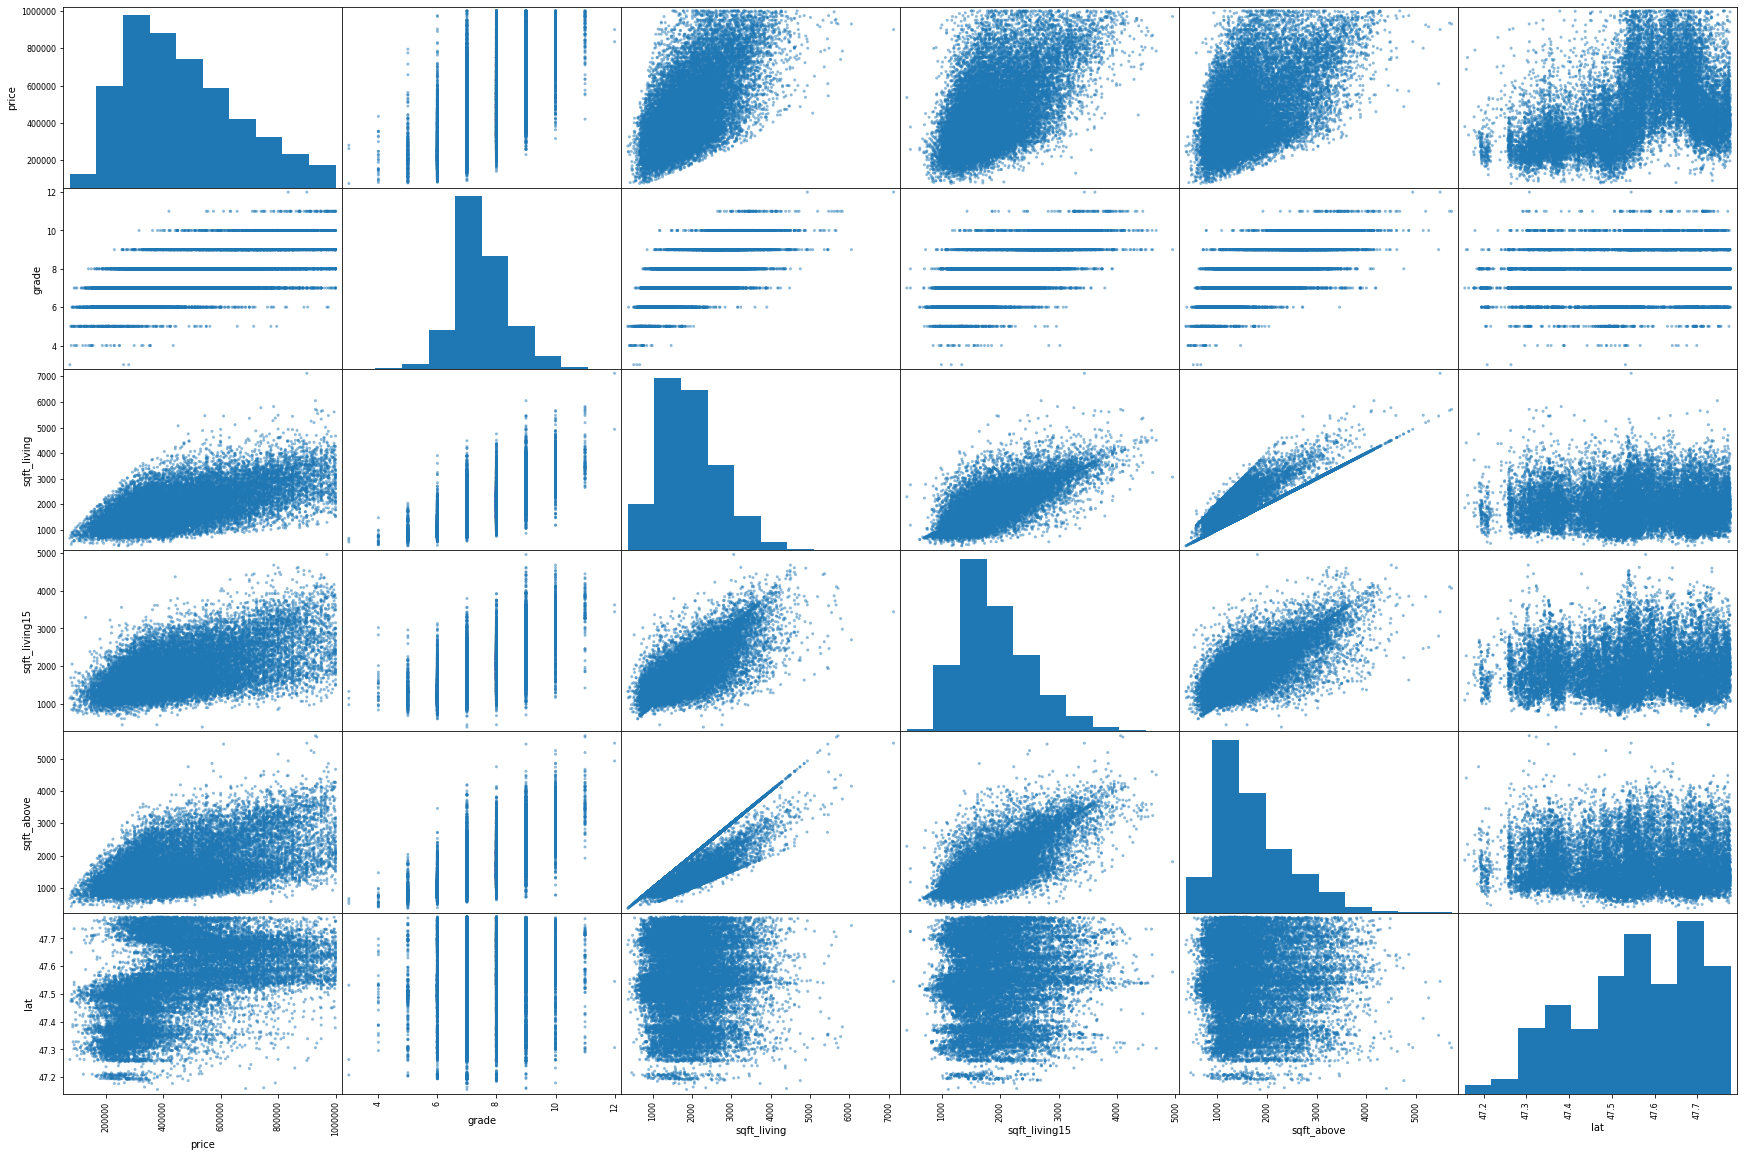

In [139]:
attributes = correlations.index[:6]
pd.plotting.scatter_matrix(housing[attributes], figsize=(30, 20))

In [136]:
print(correlations.index)

Index(['price', 'grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'lat',
       'bathrooms', 'bedrooms', 'floors', 'sqft_basement', 'view', 'sqft_lot',
       'sqft_lot15', 'long', 'yr_renovated', 'yr_built', 'waterfront',
       'price_bin', 'condition', 'zipcode'],
      dtype='object')


In [62]:
housing[housing['bathrooms'] % 1 != 0]

,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,2014-12-09,538000.0,0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5,2014-05-12,1230000.0,1,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,2014-06-27,257500.0,0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2015-01-15,291850.0,0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
9,2015-03-12,323000.0,0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014-05-21,360000.0,0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,2015-02-23,400000.0,0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,2014-06-23,402101.0,0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,2015-01-16,400000.0,0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [103]:
type(housing['price'][1])

numpy.float64